# Theft Crime Clustering in City of Chicago UsingDensity Based Algorithm

1. Data Preprocessing
    1.1 Importing Data
    1.2 Preprocessing the Datasets
    1.3 Preprocessing Shapefile
2. Plotting the point to the Shapefile
    - Change the CRS of both datasets and shapefile to ESPG: 3435
3. EDA
    3.1 Crime Type Distribution
    3.2 Theft by month in the year 2022
    3.3 Theft by Part of the Day in July 2022
4. ESTDA
    4.1 KDE in July 2022
    4.2 KDE of Part of the Day in July 2022
    4.3 3D Scatterplot 
5. Hyperparameter Tuning of Clustering
    5.1 Preparation for Hyperparameter Tuning and Exploration for the Number of Clusters
    5.2 Hyperparameter Tuning: Epsilon (eps)
    5.3 Hyperparameter Tuning: Minimum Point (MinPts)
6. Visualisation of DBSCAN
    6.1 Hyperparameter: eps=7500, MinPts=2
    6.2 Hyperparameter: eps=4500, MinPts=2
7. Visualisation of ST-DBSCAN
    7.1 Hyperparameter: eps=7500, MinPts=2
    7.2 Hyperparameter: eps=4500, MinPts=2
    7.3 Hyperparameter: eps=5000, MinPts=2


## 1. Data Preprocessing

### 1.1 Importing Data

In [100]:
#importing libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyproj
import plotly.express as px

from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from st_dbscan import ST_DBSCAN

In [101]:
#adding the data for chicago year 2022
data = pd.read_csv('2022_all_year.csv')

Looking at the column in the data

In [102]:
data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'Boundaries - ZIP Codes',
       'Police Districts', 'Police Beats'],
      dtype='object')

### 1.2 Preprocessing the Datasets

Dropping any unecessary column

In [103]:
data = data.drop(data.columns[[0,1,3,4,7,9,10,11,12,13,14,17,18,21,22,23,24,25,26,27,28,29]],axis=1)
#axis = 1 means that the operation are perform on the columns of the DataFrame

In [104]:
data.columns

Index(['Date', 'Primary Type', 'Description', 'Arrest', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude'],
      dtype='object')

In [105]:
data.head(15)

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2022 11:50:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1165385.0,1946614.0,42.009108,-87.666844
1,12/31/2022 11:50:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,False,1139357.0,1900199.0,41.882257,-87.763744
2,12/31/2022 11:47:00 PM,ASSAULT,SIMPLE,True,1167940.0,1844124.0,41.727812,-87.660399
3,12/31/2022 11:47:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1167940.0,1844124.0,41.727812,-87.660399
4,12/31/2022 11:45:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1169346.0,1830494.0,41.690379,-87.655642
5,12/31/2022 11:45:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1173883.0,1905665.0,41.896557,-87.636802
6,12/31/2022 11:45:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,False,1142695.0,1899189.0,41.879424,-87.751512
7,12/31/2022 11:45:00 PM,BATTERY,SIMPLE,False,1177394.0,1901277.0,41.884437,-87.624040
8,12/31/2022 11:44:00 PM,CRIMINAL TRESPASS,TO LAND,False,1163051.0,1889068.0,41.851248,-87.677052
9,12/31/2022 11:44:00 PM,CRIMINAL DAMAGE,TO PROPERTY,False,NaN,NaN,NaN,NaN


removing the rows with any NaN

In [106]:
data = data.dropna()
data

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2022 11:50:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1165385.0,1946614.0,42.009108,-87.666844
1,12/31/2022 11:50:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,False,1139357.0,1900199.0,41.882257,-87.763744
2,12/31/2022 11:47:00 PM,ASSAULT,SIMPLE,True,1167940.0,1844124.0,41.727812,-87.660399
3,12/31/2022 11:47:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1167940.0,1844124.0,41.727812,-87.660399
4,12/31/2022 11:45:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1169346.0,1830494.0,41.690379,-87.655642
...,...,...,...,...,...,...,...,...
237351,01/01/2022 12:00:00 AM,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,False,1169722.0,1917469.0,41.929039,-87.651740
237352,01/01/2022 12:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,False,1191357.0,1852335.0,41.749809,-87.574354
237353,01/01/2022 12:00:00 AM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,False,1166434.0,1861907.0,41.776643,-87.665410
237355,01/01/2022 12:00:00 AM,THEFT,OVER $500,False,1165777.0,1899437.0,41.879643,-87.666751


Looking at the data type of each columns

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233173 entries, 0 to 237357
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          233173 non-null  object 
 1   Primary Type  233173 non-null  object 
 2   Description   233173 non-null  object 
 3   Arrest        233173 non-null  bool   
 4   X Coordinate  233173 non-null  float64
 5   Y Coordinate  233173 non-null  float64
 6   Latitude      233173 non-null  float64
 7   Longitude     233173 non-null  float64
dtypes: bool(1), float64(4), object(3)
memory usage: 14.5+ MB


Converting the 'Date' column to a date data type 

In [108]:
data['Date']=pd.to_datetime(data['Date'])
print(data.head())

                 Date         Primary Type                    Description  \
0 2022-12-31 23:50:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   
1 2022-12-31 23:50:00              BATTERY        DOMESTIC BATTERY SIMPLE   
2 2022-12-31 23:47:00              ASSAULT                         SIMPLE   
3 2022-12-31 23:47:00    WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN   
4 2022-12-31 23:45:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   

   Arrest  X Coordinate  Y Coordinate   Latitude  Longitude  
0   False     1165385.0     1946614.0  42.009108 -87.666844  
1   False     1139357.0     1900199.0  41.882257 -87.763744  
2    True     1167940.0     1844124.0  41.727812 -87.660399  
3    True     1167940.0     1844124.0  41.727812 -87.660399  
4   False     1169346.0     1830494.0  41.690379 -87.655642  


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233173 entries, 0 to 237357
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          233173 non-null  datetime64[ns]
 1   Primary Type  233173 non-null  object        
 2   Description   233173 non-null  object        
 3   Arrest        233173 non-null  bool          
 4   X Coordinate  233173 non-null  float64       
 5   Y Coordinate  233173 non-null  float64       
 6   Latitude      233173 non-null  float64       
 7   Longitude     233173 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), object(2)
memory usage: 14.5+ MB


### 1.3 Preprocessing Shapefile

If the original shapefile fail to upload please use the shapefile of 77 community areas in Chicago in the website as follows: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [110]:
gdf = gpd.read_file('geo_chicago.shp')

In [111]:
gdf.columns


Index(['area', 'area_num_1', 'area_numbe', 'comarea', 'comarea_id',
       'community', 'perimeter', 'shape_area', 'shape_len', 'geometry'],
      dtype='object')

In [112]:
gdf

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


<AxesSubplot:>

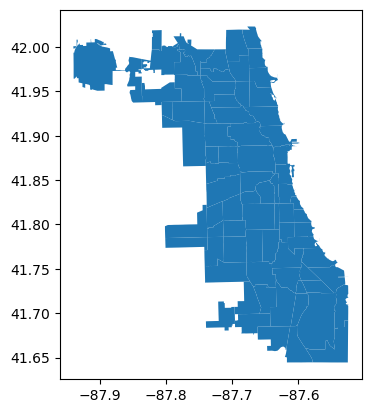

In [113]:
gdf.plot()

In [114]:
gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [115]:
#convert the shapefile from WGS84 to UTM
import pyproj

# State Plane illinois East NAD 1984 projection
target_crs = pyproj.CRS.from_epsg(3435)  # State Plane illinois East NAD 1984 projection

# Convert the geometry to the target CRS
gdf_utm = gdf.to_crs(target_crs)

# Save the new shapefile
gdf_utm.to_file('chicago.shp')


In [116]:
chicago_shp = gpd.read_file('chicago.shp')

In [117]:
chicago_shp.crs

<Derived Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [118]:
chicago_shp

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.039, 1181571.200..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((1182322.043 1876674.730, 1182323.670..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((1186289.356 1876750.733, 1186290.775..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((1158152.274 1836518.250, 1158160.983..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((1173045.882 1828593.191, 1172952.890..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((1119302.584 1938024.319, 11193..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((1168756.115 1942653.009, 1168756.116..."


<AxesSubplot:>

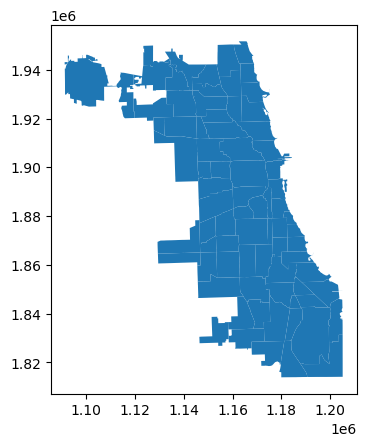

In [119]:
chicago_shp.plot()

## 2. Ploting the point to the shapefile

In [120]:
theft_jul

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night
...,...,...,...,...,...,...,...,...,...,...,...,...
5615,2022-07-01 00:00:00,THEFT,OVER $500,False,1143797.0,1895517.0,41.869327,-87.747557,7,00:00:00,0,Night
5616,2022-07-01 00:00:00,THEFT,$500 AND UNDER,False,1172352.0,1899622.0,41.880008,-87.642603,7,00:00:00,0,Night
5617,2022-07-01 00:00:00,THEFT,OVER $500,False,1137886.0,1918370.0,41.932147,-87.768706,7,00:00:00,0,Night
5618,2022-07-01 00:00:00,THEFT,OVER $500,False,1181872.0,1855091.0,41.757596,-87.609026,7,00:00:00,0,Night


Text(0.5, 1.0, 'Distribution of theft in Chicago in the Month of July 2022')

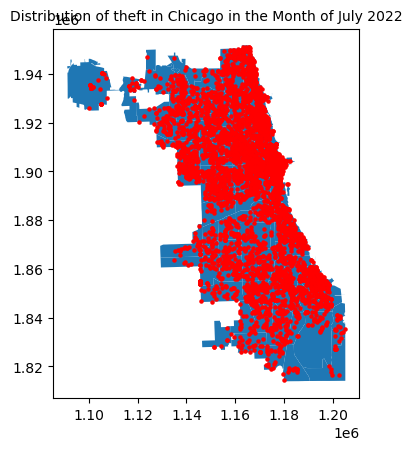

In [121]:
from shapely.geometry import Point

# Create a GeoDataFrame from the 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(theft_jul['X Coordinate'], theft_jul['Y Coordinate'])]
gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:26910')

# Plot the GeoDataFrame on top of the shapefile
ax = chicago_shp.plot()
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# set plot title
plt.title('Distribution of theft in Chicago in the Month of July 2022', fontsize=10)


In [122]:
# Reset the index of both DataFrames
theft_jul = theft_jul.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)

# Concatenate the two DataFrames along the columns axis
theft_final = pd.concat([theft_jul, gdf], axis=1)

In [123]:
theft_final

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day,geometry
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night,POINT (1153054.000 1863585.000)
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night,POINT (1176400.000 1899863.000)
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night,POINT (1170781.000 1898712.000)
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night,POINT (1184328.000 1850665.000)
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night,POINT (1185140.000 1869552.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,2022-07-01 00:00:00,THEFT,OVER $500,False,1143797.0,1895517.0,41.869327,-87.747557,7,00:00:00,0,Night,POINT (1143797.000 1895517.000)
5616,2022-07-01 00:00:00,THEFT,$500 AND UNDER,False,1172352.0,1899622.0,41.880008,-87.642603,7,00:00:00,0,Night,POINT (1172352.000 1899622.000)
5617,2022-07-01 00:00:00,THEFT,OVER $500,False,1137886.0,1918370.0,41.932147,-87.768706,7,00:00:00,0,Night,POINT (1137886.000 1918370.000)
5618,2022-07-01 00:00:00,THEFT,OVER $500,False,1181872.0,1855091.0,41.757596,-87.609026,7,00:00:00,0,Night,POINT (1181872.000 1855091.000)


In [124]:
# Check for NaN values in the DataFrame
print(theft_final.isna().any())

Date            False
Primary Type    False
Description     False
Arrest          False
X Coordinate    False
Y Coordinate    False
Latitude        False
Longitude       False
Month           False
Hour            False
Hour_Only       False
Part of Day     False
geometry        False
dtype: bool


In [125]:
theft_final.shape

(5620, 13)

In [126]:
#exporting the theff crime type
theft_final.to_csv('theft_final.csv', index=False)

## 3. Exploratory Data Analysis (EDA)

### 3.1 Crime Type Distribution

In [127]:
crime = data['Primary Type'].unique()
print(crime ,'\n')
print('Number of type of crime: ', len(crime))

['MOTOR VEHICLE THEFT' 'BATTERY' 'ASSAULT' 'WEAPONS VIOLATION'
 'OTHER OFFENSE' 'CRIMINAL TRESPASS' 'CRIMINAL DAMAGE' 'BURGLARY'
 'HOMICIDE' 'SEX OFFENSE' 'THEFT' 'ROBBERY' 'NARCOTICS'
 'DECEPTIVE PRACTICE' 'PUBLIC PEACE VIOLATION'
 'OFFENSE INVOLVING CHILDREN' 'STALKING' 'ARSON' 'CRIMINAL SEXUAL ASSAULT'
 'INTIMIDATION' 'KIDNAPPING' 'INTERFERENCE WITH PUBLIC OFFICER'
 'CONCEALED CARRY LICENSE VIOLATION' 'OBSCENITY'
 'OTHER NARCOTIC VIOLATION' 'PROSTITUTION' 'NON-CRIMINAL'
 'LIQUOR LAW VIOLATION' 'HUMAN TRAFFICKING' 'PUBLIC INDECENCY' 'GAMBLING'] 

Number of type of crime:  31


In [128]:
crime = pd.DataFrame(data['Primary Type'].value_counts())
crime.iloc[:,]


,Primary Type
THEFT,53138
BATTERY,40693
CRIMINAL DAMAGE,26912
MOTOR VEHICLE THEFT,21268
ASSAULT,20691
DECEPTIVE PRACTICE,14761
OTHER OFFENSE,14232
ROBBERY,8953
WEAPONS VIOLATION,8697
BURGLARY,7520


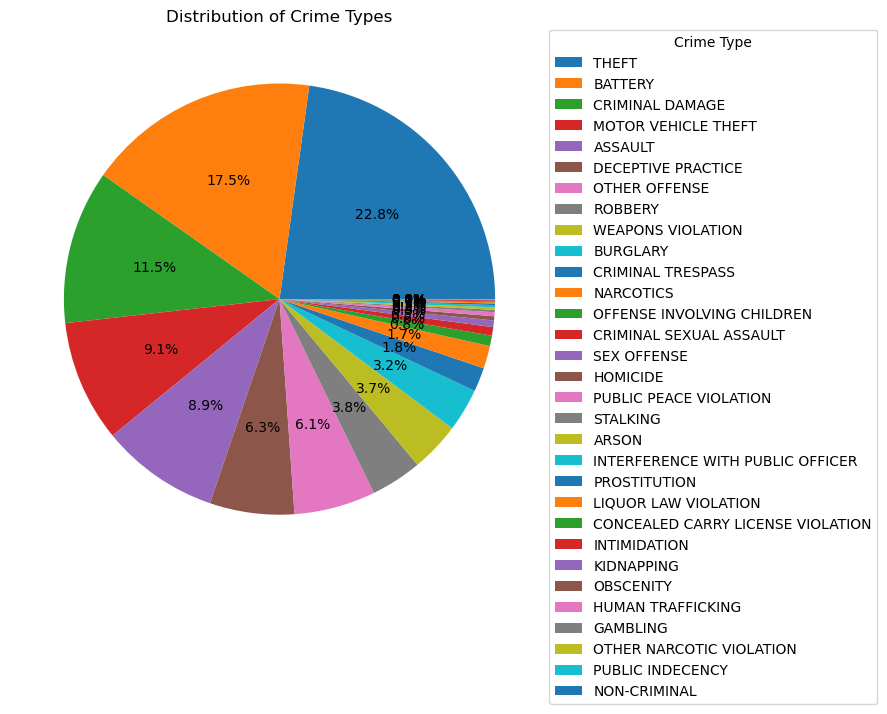

In [129]:

# Count the occurrences of each crime type
crime_counts = data['Primary Type'].value_counts()

# Sort the crime types by the number of crimes in descending order
crime_counts = crime_counts.sort_values(ascending=False)

# Create a pie chart using pandas
fig, ax = plt.subplots(figsize=(20, 7))
ax.pie(crime_counts.values, labels=None, autopct='%1.1f%%')
ax.set_title('Distribution of Crime Types')

# Show the plot
plt.legend(labels=crime_counts.index, bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0, title='Crime Type')
plt.show()

Theft is choosen as it is the highest type of crime rate 

In [130]:
theft = data[data['Primary Type'].str.startswith('THEFT')]
theft

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
53,2022-12-31 22:30:00,THEFT,FROM BUILDING,False,1179396.0,1903711.0,41.891070,-87.616614
82,2022-12-31 21:50:00,THEFT,OVER $500,False,1137758.0,1867507.0,41.792574,-87.770402
99,2022-12-31 21:12:00,THEFT,RETAIL THEFT,False,1161020.0,1870793.0,41.801141,-87.685012
105,2022-12-31 21:00:00,THEFT,OVER $500,False,1155665.0,1890311.0,41.854810,-87.704127
111,2022-12-31 21:00:00,THEFT,$500 AND UNDER,False,1177991.0,1856429.0,41.761357,-87.623209
...,...,...,...,...,...,...,...,...
237329,2022-01-01 00:00:00,THEFT,$500 AND UNDER,False,1148721.0,1913242.0,41.917872,-87.729022
237333,2022-01-01 00:00:00,THEFT,OVER $500,False,1159793.0,1874504.0,41.811350,-87.689410
237341,2022-01-01 00:00:00,THEFT,$500 AND UNDER,False,1171333.0,1891003.0,41.856380,-87.646598
237350,2022-01-01 00:00:00,THEFT,POCKET-PICKING,False,1171576.0,1915192.0,41.922751,-87.644994


Plotting theft by the months. To do so we have to separate our Date into monthly and hoursly by creating a new column 'Month' and 'Hour'

In [131]:
# Convert the 'Date' column to datetime format
theft['Date'] =  pd.to_datetime(theft['Date'])

# Extract the month and hourly information using the 'dt' accessor
theft['Month'] = theft['Date'].dt.month
theft['Hour'] = theft['Date'].dt.strftime('%H:%M:%S')

C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\3877458148.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\3877458148.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\3877458148.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [132]:
theft.columns

Index(['Date', 'Primary Type', 'Description', 'Arrest', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude', 'Month', 'Hour'],
      dtype='object')

In [133]:
theft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53138 entries, 53 to 237355
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          53138 non-null  datetime64[ns]
 1   Primary Type  53138 non-null  object        
 2   Description   53138 non-null  object        
 3   Arrest        53138 non-null  bool          
 4   X Coordinate  53138 non-null  float64       
 5   Y Coordinate  53138 non-null  float64       
 6   Latitude      53138 non-null  float64       
 7   Longitude     53138 non-null  float64       
 8   Month         53138 non-null  int64         
 9   Hour          53138 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [134]:
theft.head()

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour
53,2022-12-31 22:30:00,THEFT,FROM BUILDING,False,1179396.0,1903711.0,41.891070,-87.616614,12,22:30:00
82,2022-12-31 21:50:00,THEFT,OVER $500,False,1137758.0,1867507.0,41.792574,-87.770402,12,21:50:00
99,2022-12-31 21:12:00,THEFT,RETAIL THEFT,False,1161020.0,1870793.0,41.801141,-87.685012,12,21:12:00
105,2022-12-31 21:00:00,THEFT,OVER $500,False,1155665.0,1890311.0,41.854810,-87.704127,12,21:00:00
111,2022-12-31 21:00:00,THEFT,$500 AND UNDER,False,1177991.0,1856429.0,41.761357,-87.623209,12,21:00:00


In [135]:
theft.shape

(53138, 10)

### 3.2 Theft by Month in the year 2022

In [136]:
theft_month = pd.DataFrame(theft['Month'].value_counts())
theft_month.iloc[:,]

,Month
7,5620
8,5146
10,5123
9,5017
6,4971
11,4577
5,4443
3,3956
12,3932
4,3880


C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\1662820222.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




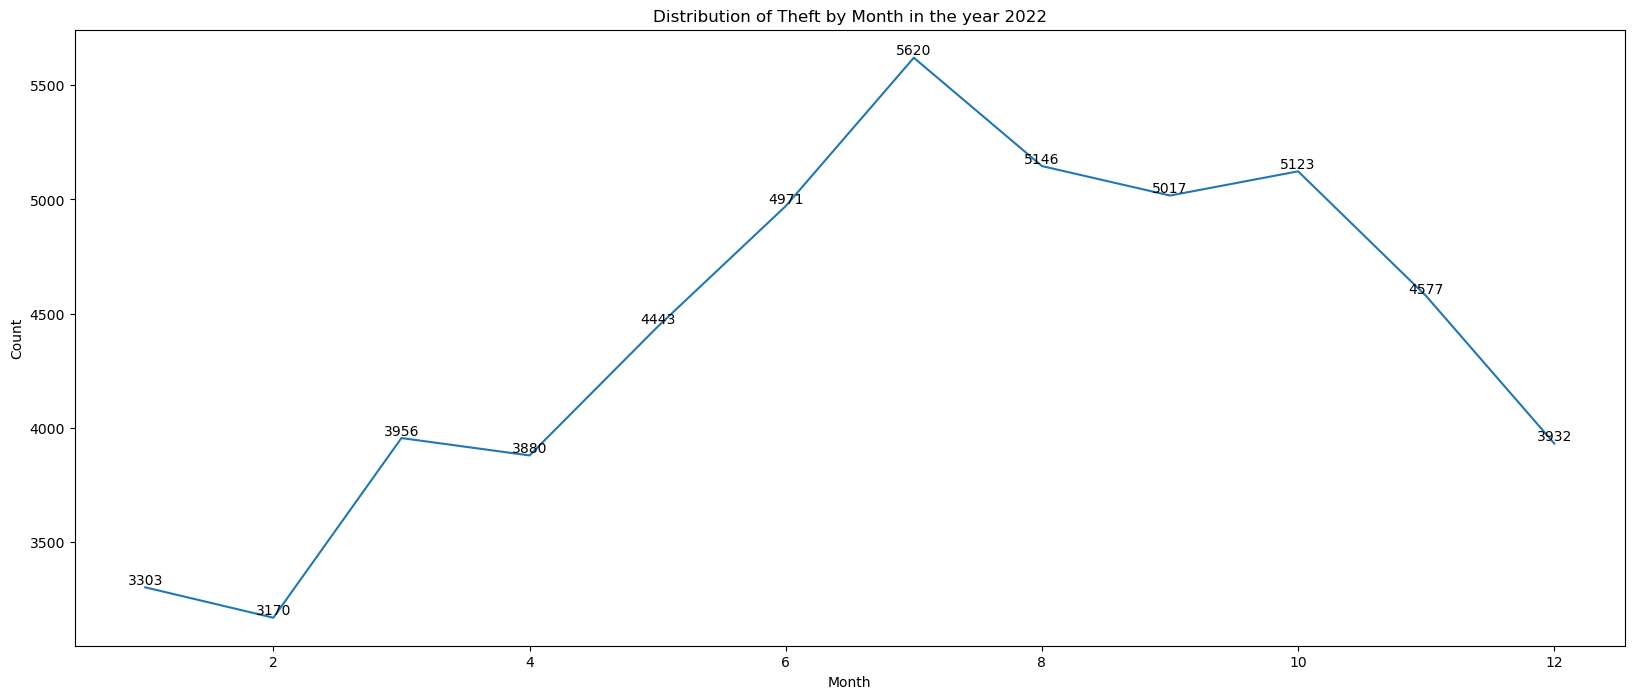

In [137]:
# Create a line plot with count values
graph = sns.lineplot(x='Month', y='count', data=theft.groupby('Month').size().reset_index(name='count'), ci=None)

# Add count values as text labels
for index, row in theft.groupby('Month').size().reset_index(name='count').iterrows():
    graph.annotate(row['count'], xy=(row['Month'], row['count']), ha='center', va='bottom')

# Set the title and axis labels
graph.set(title='Distribution of Theft by Month in the year 2022', xlabel='Month', ylabel='Count')

# Set the figure size
graph.figure.set_size_inches(20, 8)

# Show the plot
plt.show()

In [138]:
theft.head()

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour
53,2022-12-31 22:30:00,THEFT,FROM BUILDING,False,1179396.0,1903711.0,41.891070,-87.616614,12,22:30:00
82,2022-12-31 21:50:00,THEFT,OVER $500,False,1137758.0,1867507.0,41.792574,-87.770402,12,21:50:00
99,2022-12-31 21:12:00,THEFT,RETAIL THEFT,False,1161020.0,1870793.0,41.801141,-87.685012,12,21:12:00
105,2022-12-31 21:00:00,THEFT,OVER $500,False,1155665.0,1890311.0,41.854810,-87.704127,12,21:00:00
111,2022-12-31 21:00:00,THEFT,$500 AND UNDER,False,1177991.0,1856429.0,41.761357,-87.623209,12,21:00:00


In [139]:
theft_jul = theft.loc[theft['Month'] == 7]

In [140]:
theft_jul.shape

(5620, 10)

In [141]:
theft_jul

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour
107587,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00
107593,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00
107599,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00
107602,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00
107604,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00
...,...,...,...,...,...,...,...,...,...,...
129696,2022-07-01 00:00:00,THEFT,OVER $500,False,1143797.0,1895517.0,41.869327,-87.747557,7,00:00:00
129697,2022-07-01 00:00:00,THEFT,$500 AND UNDER,False,1172352.0,1899622.0,41.880008,-87.642603,7,00:00:00
129704,2022-07-01 00:00:00,THEFT,OVER $500,False,1137886.0,1918370.0,41.932147,-87.768706,7,00:00:00
129708,2022-07-01 00:00:00,THEFT,OVER $500,False,1181872.0,1855091.0,41.757596,-87.609026,7,00:00:00


### 3.3 Theft by Part of the Day in July 2022

EDA on the hourly

In [142]:
# convert Hour column to datetime format
theft_jul['Hour_Only'] = pd.to_datetime(theft_jul['Hour'], format='%H:%M:%S').dt.hour

# define function to categorize hours
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# apply categorize_hour function to Hour column
theft_jul['Part of Day'] = theft_jul['Hour_Only'].apply(categorize_hour)

# print resulting dataframe
print(theft_jul)

                      Date Primary Type     Description  Arrest  X Coordinate  \
107587 2022-07-31 23:30:00        THEFT  $500 AND UNDER   False     1153054.0   
107593 2022-07-31 23:18:00        THEFT       OVER $500   False     1176400.0   
107599 2022-07-31 23:00:00        THEFT       OVER $500   False     1170781.0   
107602 2022-07-31 23:00:00        THEFT  $500 AND UNDER   False     1184328.0   
107604 2022-07-31 23:00:00        THEFT       OVER $500   False     1185140.0   
...                    ...          ...             ...     ...           ...   
129696 2022-07-01 00:00:00        THEFT       OVER $500   False     1143797.0   
129697 2022-07-01 00:00:00        THEFT  $500 AND UNDER   False     1172352.0   
129704 2022-07-01 00:00:00        THEFT       OVER $500   False     1137886.0   
129708 2022-07-01 00:00:00        THEFT       OVER $500   False     1181872.0   
129719 2022-07-01 00:00:00        THEFT  $500 AND UNDER   False     1177659.0   

        Y Coordinate   Lati

C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\1894376262.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zohar\AppData\Local\Temp\ipykernel_11156\1894376262.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [143]:
theft_jul.columns

Index(['Date', 'Primary Type', 'Description', 'Arrest', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude', 'Month', 'Hour', 'Hour_Only',
       'Part of Day'],
      dtype='object')

In [144]:
theft_jul.info

<bound method DataFrame.info of                       Date Primary Type     Description  Arrest  X Coordinate  \
107587 2022-07-31 23:30:00        THEFT  $500 AND UNDER   False     1153054.0   
107593 2022-07-31 23:18:00        THEFT       OVER $500   False     1176400.0   
107599 2022-07-31 23:00:00        THEFT       OVER $500   False     1170781.0   
107602 2022-07-31 23:00:00        THEFT  $500 AND UNDER   False     1184328.0   
107604 2022-07-31 23:00:00        THEFT       OVER $500   False     1185140.0   
...                    ...          ...             ...     ...           ...   
129696 2022-07-01 00:00:00        THEFT       OVER $500   False     1143797.0   
129697 2022-07-01 00:00:00        THEFT  $500 AND UNDER   False     1172352.0   
129704 2022-07-01 00:00:00        THEFT       OVER $500   False     1137886.0   
129708 2022-07-01 00:00:00        THEFT       OVER $500   False     1181872.0   
129719 2022-07-01 00:00:00        THEFT  $500 AND UNDER   False     1177659.0

In [145]:
theft_jul.head()

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day
107587,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night
107593,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night
107599,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night
107602,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night
107604,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night


In [146]:
theft_part_the_day = pd.DataFrame(theft_jul['Part of Day'].value_counts())
theft_part_the_day.iloc[:,]

,Part of Day
Night,1694
Afternoon,1501
Evening,1240
Morning,1185


In [147]:
theft_part_the_day.shape

(4, 1)

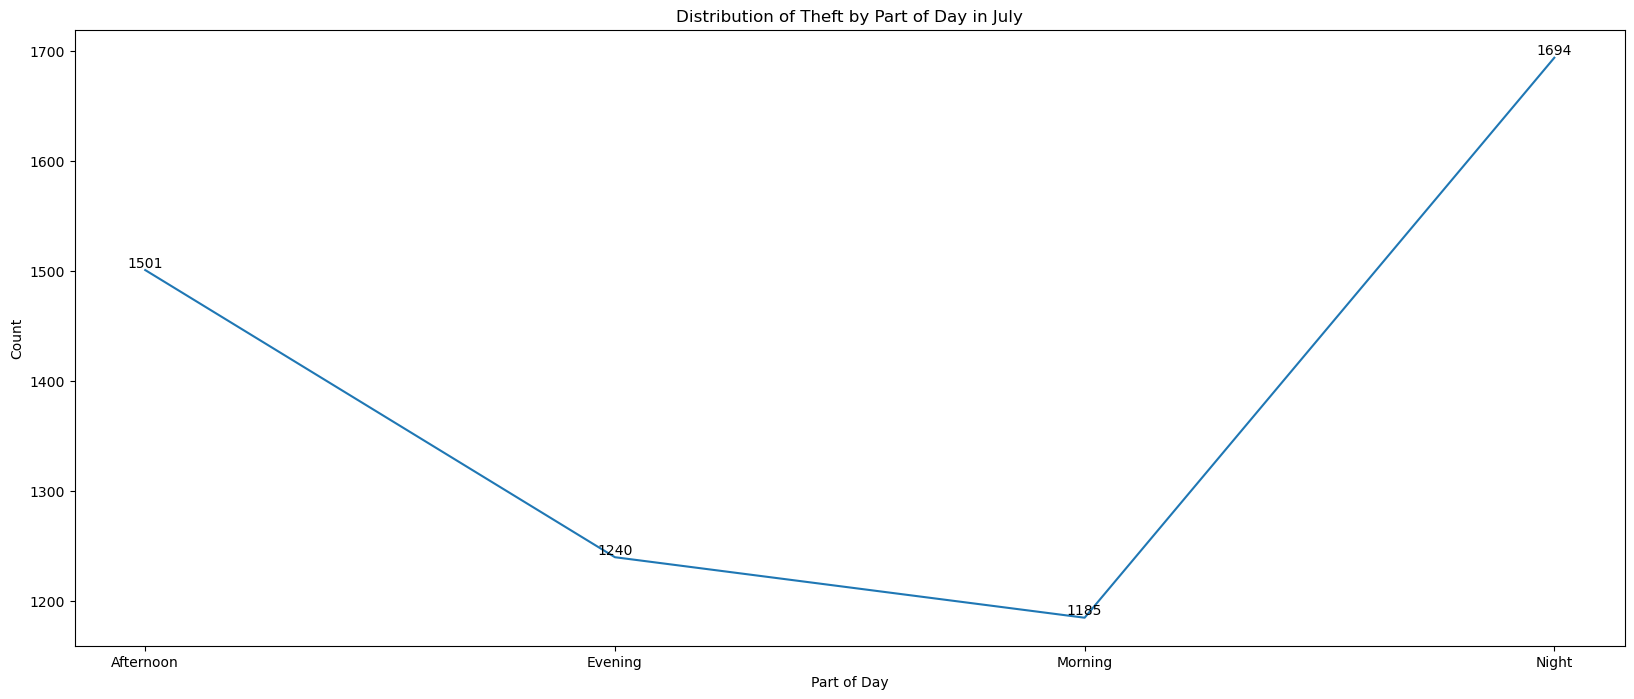

In [148]:
# Group the data by Part of Day and count the occurrences
theft_counts = theft_jul.groupby('Part of Day').size().reset_index(name='count')

# Create a line plot with count values
graph = sns.lineplot(x='Part of Day', y='count', data=theft_counts)

# Add count values as text labels
for index, row in theft_counts.iterrows():
    graph.annotate(row['count'], xy=(row['Part of Day'], row['count']), ha='center', va='bottom')

# Set the title and axis labels
graph.set(title='Distribution of Theft by Part of Day in July', xlabel='Part of Day', ylabel='Count')

# Set the figure size
graph.figure.set_size_inches(20, 8)

# Show the plot
plt.show()

In [149]:
theft_part_the_day

,Part of Day
Night,1694
Afternoon,1501
Evening,1240
Morning,1185


## 4. Exploratory Spatial Temporal Data Analysis (ESTDA)

### 4.1 Kernel Density Estimation (KDE) in July 2022

In [150]:
df = pd.read_csv('theft_final.csv')

In [151]:
df.head()

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day,geometry
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night,POINT (1153054 1863585)
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night,POINT (1176400 1899863)
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night,POINT (1170781 1898712)
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night,POINT (1184328 1850665)
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night,POINT (1185140 1869552)


In [152]:
def kde(time_scale, data):
    fig, ax = plt.subplots(1, figsize=(12, 10))
    chicago_shp.plot(color='white', edgecolor='black', ax=ax)
    sns.kdeplot(x='X Coordinate', y='Y Coordinate', data=data, cmap='flare', fill=True, alpha=0.7, cbar=True, levels=20, thresh=0.05)
    ax.set(title='Theft in Chicago in ' + str(time_scale))
    plt.show()


 #In this code, the kernel used is a Gaussian kernel and the bandwidth is automatically selected by the kdeplot() function using the Scott's rule.

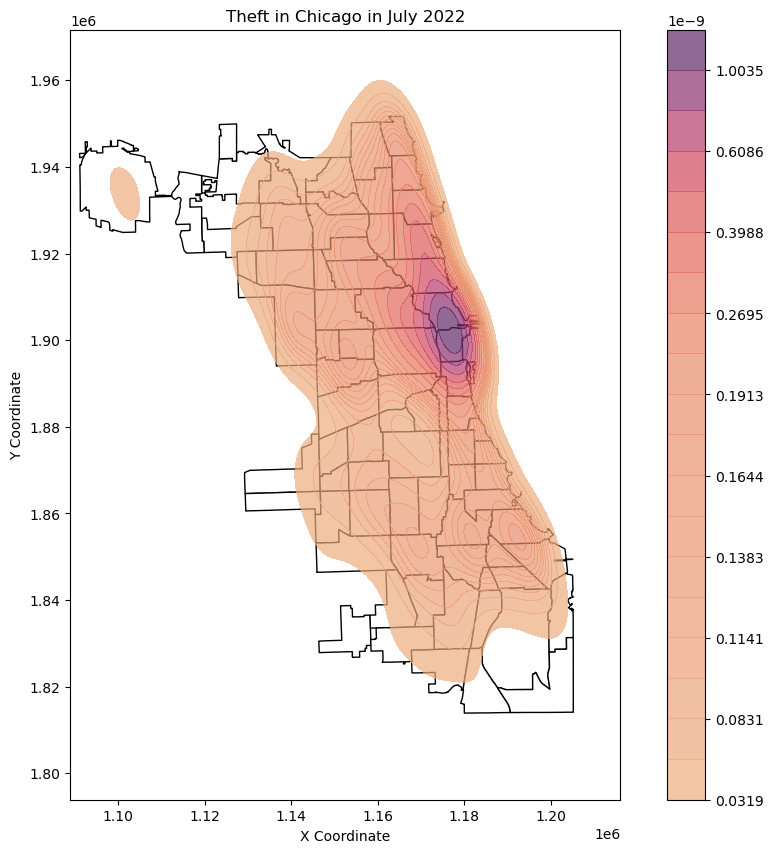

In [153]:
kde('July 2022', df)

### 4.2 Kernel Density Estimation (KDE) of Part of Day in July 2022

In [154]:
#Separating the four categories part of day
df_morning = df.loc[df['Part of Day'] == 'Morning']
#df_morning

df_afternoon = df.loc[df['Part of Day'] == 'Afternoon']
#df_afternoon

df_evening = df.loc[df['Part of Day'] == 'Evening']
#df_evening

df_night = df.loc[df['Part of Day'] == 'Night']
#df_night

In [155]:
df_night

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day,geometry
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night,POINT (1153054 1863585)
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night,POINT (1176400 1899863)
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night,POINT (1170781 1898712)
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night,POINT (1184328 1850665)
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night,POINT (1185140 1869552)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,2022-07-01 00:00:00,THEFT,OVER $500,False,1143797.0,1895517.0,41.869327,-87.747557,7,00:00:00,0,Night,POINT (1143797 1895517)
5616,2022-07-01 00:00:00,THEFT,$500 AND UNDER,False,1172352.0,1899622.0,41.880008,-87.642603,7,00:00:00,0,Night,POINT (1172352 1899622)
5617,2022-07-01 00:00:00,THEFT,OVER $500,False,1137886.0,1918370.0,41.932147,-87.768706,7,00:00:00,0,Night,POINT (1137886 1918370)
5618,2022-07-01 00:00:00,THEFT,OVER $500,False,1181872.0,1855091.0,41.757596,-87.609026,7,00:00:00,0,Night,POINT (1181872 1855091)


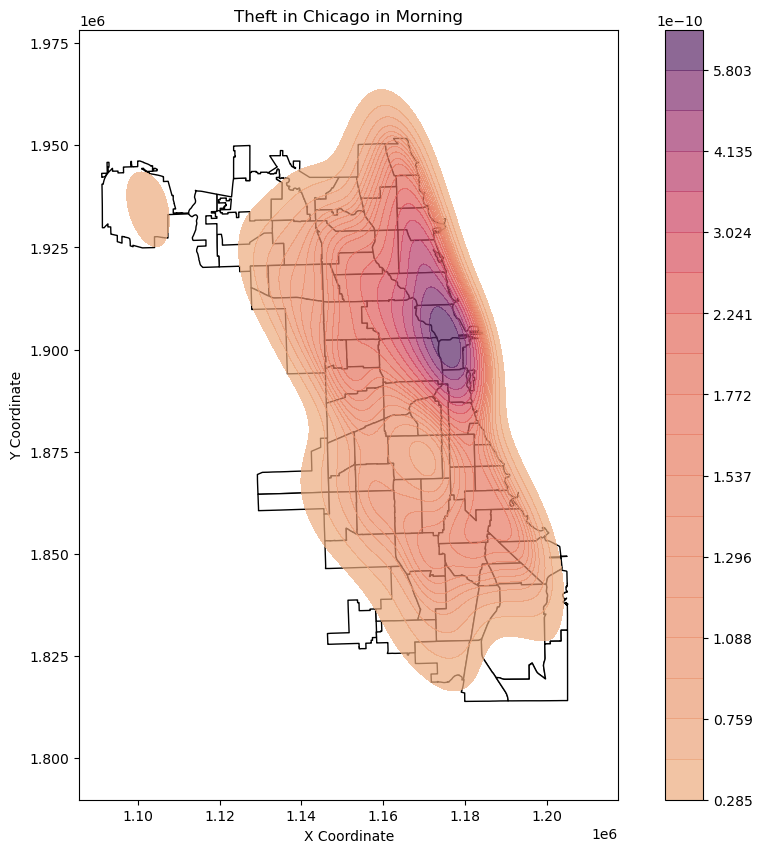

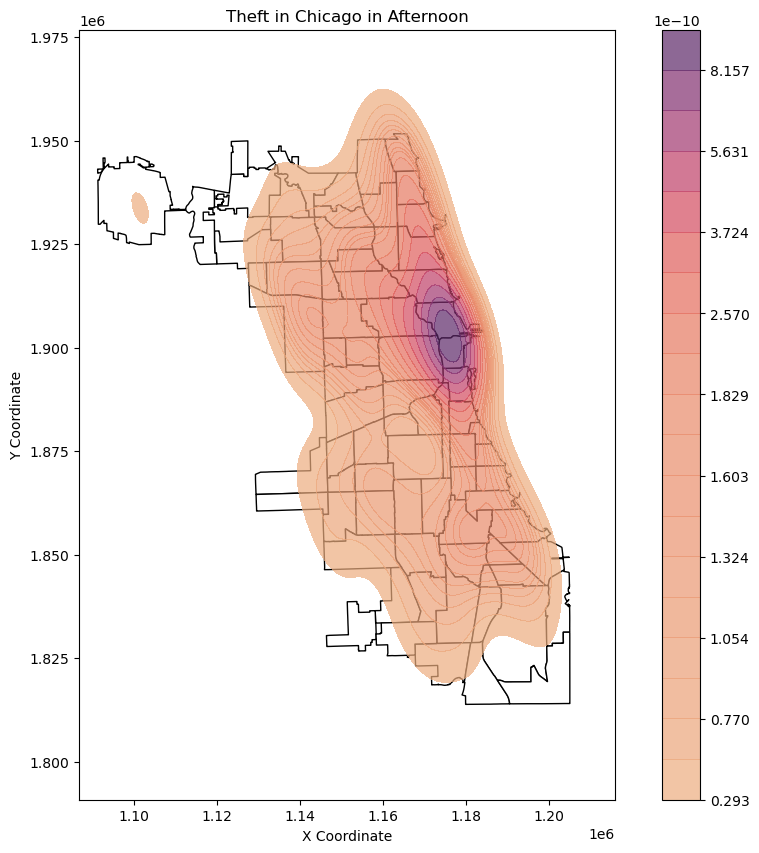

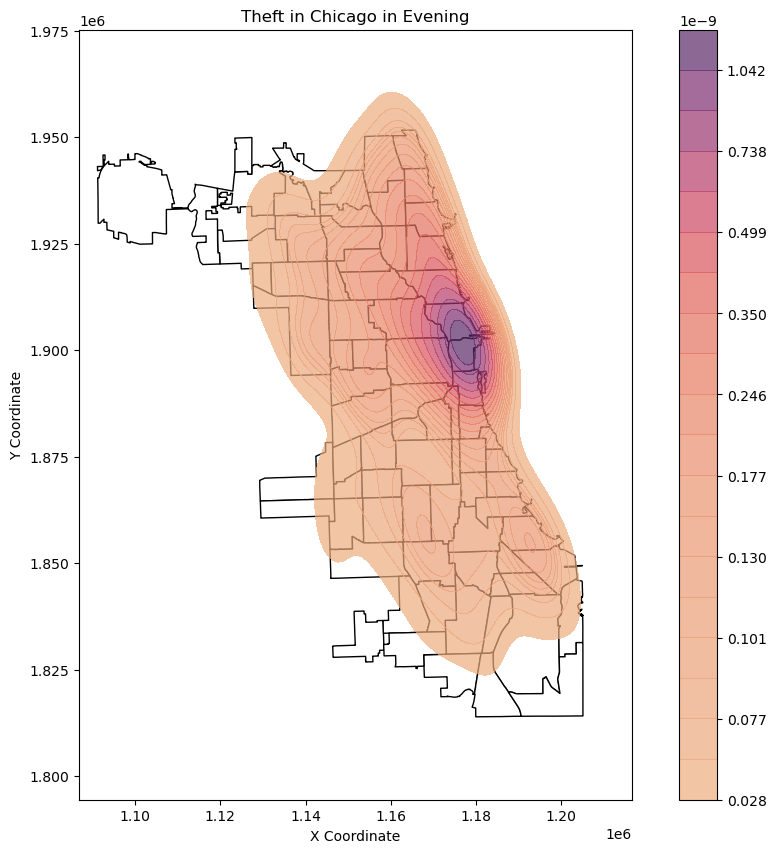

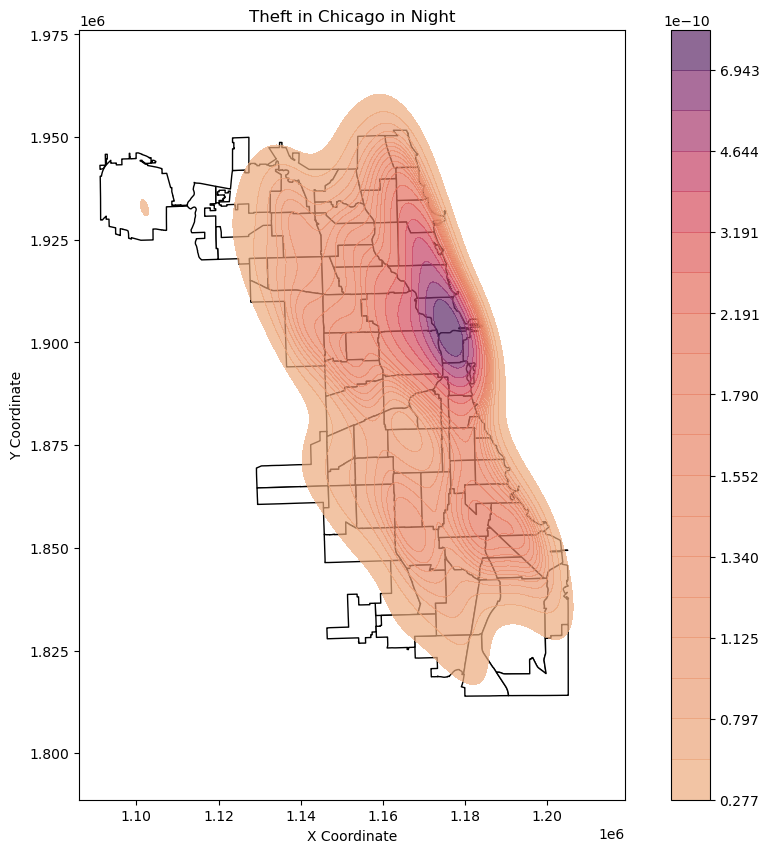

In [156]:
kde('Morning', df_morning)
kde('Afternoon', df_afternoon)
kde('Evening', df_evening)
kde('Night', df_night)

### 4.3 Clustering Visualisation -3D Scatterplot of Part of the Day in July 2022

In [157]:
import plotly.express as px

# df['Part of Day'] = df['Part of Day'].astype(int)  # Convert 'Month' to integer
# df = df.sort_values('Part of Day')
# df['Month'] = df['Month'].astype(str)  # Convert back to string for plotting
fig = px.scatter_3d(df, x='X Coordinate', y='Y Coordinate', z='Part of Day', color='Part of Day')
fig.update_layout(scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Part of Day'),
        margin=dict(l=1, r=5, b=7, t=40))
fig.show()

## 5. Hyperparameter Tuning for Density Based Clustering

### 5.1 Preparing for Hyperparameter Tuning and exploring No. of Clusters

DSCAN: Density Based Spatially Clustering of Application with Noise

There 2 important parameter in DBSCAN
- minimum point: the number of points that must exists within epsilon distance from the point
- epsilon: the distance around each object

but to find what are the optimal cluster we use the elbow method of kmeans

ST-DBSCAN:
is an extension of DBSCAN and takes an extra parameter which is the temporal epsilon

In [158]:
df

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day,geometry
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,Night,POINT (1153054 1863585)
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,Night,POINT (1176400 1899863)
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,Night,POINT (1170781 1898712)
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,Night,POINT (1184328 1850665)
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,Night,POINT (1185140 1869552)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,2022-07-01 00:00:00,THEFT,OVER $500,False,1143797.0,1895517.0,41.869327,-87.747557,7,00:00:00,0,Night,POINT (1143797 1895517)
5616,2022-07-01 00:00:00,THEFT,$500 AND UNDER,False,1172352.0,1899622.0,41.880008,-87.642603,7,00:00:00,0,Night,POINT (1172352 1899622)
5617,2022-07-01 00:00:00,THEFT,OVER $500,False,1137886.0,1918370.0,41.932147,-87.768706,7,00:00:00,0,Night,POINT (1137886 1918370)
5618,2022-07-01 00:00:00,THEFT,OVER $500,False,1181872.0,1855091.0,41.757596,-87.609026,7,00:00:00,0,Night,POINT (1181872 1855091)


In [159]:
#changing the Part of the day to numeric
df['Part of Day'] = [str(i).replace("Morning", "1") for i in df['Part of Day']]
df['Part of Day'] = [str(i).replace("Afternoon", "2") for i in df['Part of Day']]
df['Part of Day'] = [str(i).replace("Evening", "3") for i in df['Part of Day']]
df['Part of Day'] = [str(i).replace("Night", "4") for i in df['Part of Day']]

In [160]:
df.shape

(5620, 13)

In [161]:
df.head()

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Hour,Hour_Only,Part of Day,geometry
0,2022-07-31 23:30:00,THEFT,$500 AND UNDER,False,1153054.0,1863585.0,41.781523,-87.714417,7,23:30:00,23,4,POINT (1153054 1863585)
1,2022-07-31 23:18:00,THEFT,OVER $500,False,1176400.0,1899863.0,41.880579,-87.627733,7,23:18:00,23,4,POINT (1176400 1899863)
2,2022-07-31 23:00:00,THEFT,OVER $500,False,1170781.0,1898712.0,41.877546,-87.648399,7,23:00:00,23,4,POINT (1170781 1898712)
3,2022-07-31 23:00:00,THEFT,$500 AND UNDER,False,1184328.0,1850665.0,41.745394,-87.600163,7,23:00:00,23,4,POINT (1184328 1850665)
4,2022-07-31 23:00:00,THEFT,OVER $500,False,1185140.0,1869552.0,41.797203,-87.596595,7,23:00:00,23,4,POINT (1185140 1869552)


In [162]:
#filtering to only the column that are needed into an array
df_clus= df.iloc[:, [11,4,5]].values

In [163]:
df_clus

array([['4', 1153054.0, 1863585.0],
       ['4', 1176400.0, 1899863.0],
       ['4', 1170781.0, 1898712.0],
       ...,
       ['4', 1137886.0, 1918370.0],
       ['4', 1181872.0, 1855091.0],
       ['4', 1177659.0, 1868284.0]], dtype=object)

In [164]:
df_clus[:,0] = df_clus[:,0].astype(float)

In [165]:
df_clus

array([[4.0, 1153054.0, 1863585.0],
       [4.0, 1176400.0, 1899863.0],
       [4.0, 1170781.0, 1898712.0],
       ...,
       [4.0, 1137886.0, 1918370.0],
       [4.0, 1181872.0, 1855091.0],
       [4.0, 1177659.0, 1868284.0]], dtype=object)

In [166]:
df_clus = df_clus.astype(float)

In [167]:
df_clus

array([[4.000000e+00, 1.153054e+06, 1.863585e+06],
       [4.000000e+00, 1.176400e+06, 1.899863e+06],
       [4.000000e+00, 1.170781e+06, 1.898712e+06],
       ...,
       [4.000000e+00, 1.137886e+06, 1.918370e+06],
       [4.000000e+00, 1.181872e+06, 1.855091e+06],
       [4.000000e+00, 1.177659e+06, 1.868284e+06]])

In [168]:
df_clus.shape


(5620, 3)

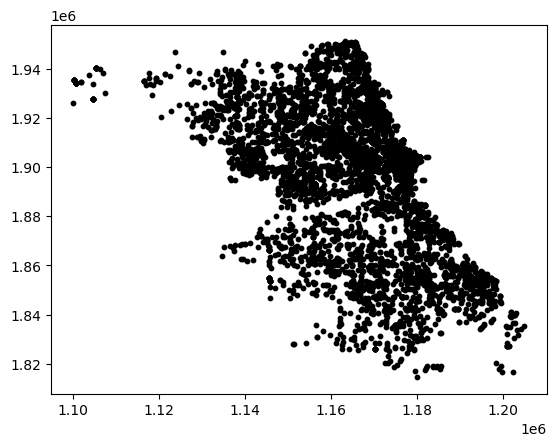

In [169]:
#roughly plotting to see
plt.scatter(df_clus[:,1], df_clus[:,2], s=10, c='black')

adapt from:https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289

Just as experiment and to have the overall picture. let us find what are the combination of number of clustering and its Silhoutte Score

Using Kmeans algorithm along with Silhoutte distance.
Silhoutte metric is a distance calculation algorithm using euclidean or manhattan distance. A silhoutte Score aways ranges between 1 to -1. A high Sillhoute Score suggests that the objects are well matched to their own cluster and poorly matched to their neighbourhood clusters. 

In [170]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = range(2,21)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(df_clus)

    silhouette_avg = silhouette_score(df_clus, cluster_labels)
    print('For n_clusters =', n_clusters, 'The silhouette_score is: ', silhouette_avg)

    #compute the silhoutte scores for each samples
    sample_silhouette_values = silhouette_samples(df_clus,cluster_labels)

For n_clusters = 2 The silhouette_score is:  0.5483687405197528
For n_clusters = 3 The silhouette_score is:  0.4599346490235893
For n_clusters = 4 The silhouette_score is:  0.46765008509249856
For n_clusters = 5 The silhouette_score is:  0.44189009260832945
For n_clusters = 6 The silhouette_score is:  0.44816167608689983
For n_clusters = 7 The silhouette_score is:  0.4527904768150138
For n_clusters = 8 The silhouette_score is:  0.43218693951089165
For n_clusters = 9 The silhouette_score is:  0.4455765072614078
For n_clusters = 10 The silhouette_score is:  0.4514058446129793
For n_clusters = 11 The silhouette_score is:  0.44874167682956145
For n_clusters = 12 The silhouette_score is:  0.44003664403061693
For n_clusters = 13 The silhouette_score is:  0.4461101877347465
For n_clusters = 14 The silhouette_score is:  0.44689094053921824
For n_clusters = 15 The silhouette_score is:  0.43138314336477224
For n_clusters = 16 The silhouette_score is:  0.41911178852786285
For n_clusters = 17 The 

In [171]:
df_clus.shape

(5620, 3)

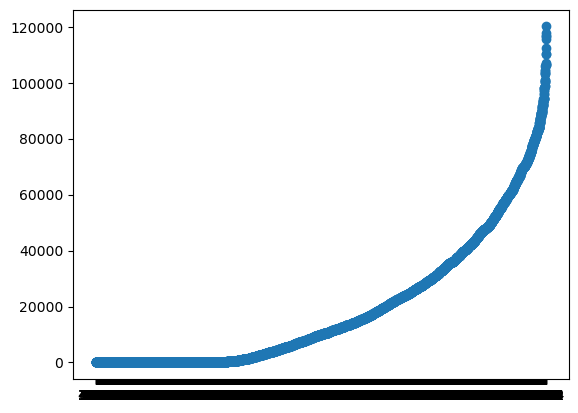

In [172]:
#using euclidean distance to find epsilon distance range
df_euc = pd.DataFrame(df_clus, columns=[0, 1, 2])
#df_euc = df_clus.iloc[:, 1:3]

df1 = df_euc.sort_values(by=[1,2])
df2 = pd.DataFrame(columns=['index','distance'])
for i in range (0, len(df1)-1):
    dist = np.linalg.norm(df1.iloc[i]-df1.iloc[i+1])
    df2 = df2.append({'index':str(i),'distance':dist}, ignore_index=True)

df2 = df2.sort_values(by=['distance'])
plt.scatter(df2['index'],df2['distance'])
plt.show()


### 5.2 Hyperparameter Tuning: Epsilon(eps)


In [173]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

range_eps = range(1, 25000, 1000)
for i in range_eps:
    print("eps value is " + str(i))
    db = DBSCAN(eps=i, min_samples=5).fit(df1)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print("For eps value =", i, "The number of clusters is:", n_clusters, "The average silhouette score is:", silhouette_avg)
    else:
        print("For eps value =", i, "Only one cluster was found.")


eps value is 1
For eps value = 1 The number of clusters is: 61 The average silhouette score is: -0.5740204327476852
eps value is 1001
For eps value = 1001 The number of clusters is: 177 The average silhouette score is: -0.13084351074834655
eps value is 2001
For eps value = 2001 The number of clusters is: 28 The average silhouette score is: -0.385385577347926
eps value is 3001
For eps value = 3001 The number of clusters is: 9 The average silhouette score is: 0.08133573649921122
eps value is 4001
For eps value = 4001 The number of clusters is: 6 The average silhouette score is: 0.18899365270733345
eps value is 5001
For eps value = 5001 The number of clusters is: 3 The average silhouette score is: 0.18817291899166766
eps value is 6001
For eps value = 6001 The number of clusters is: 3 The average silhouette score is: 0.1519283395971637
eps value is 7001
For eps value = 7001 The number of clusters is: 3 The average silhouette score is: 0.3123421318524496
eps value is 8001
For eps value = 80

In [174]:
#because the silhoutte score found the highest around 7001-10001. we will iterate again

range_eps = range(4000, 10001, 500)
for i in range_eps:
    print("eps value is " + str(i))
    db = DBSCAN(eps=i, min_samples=5).fit(df1)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print("For eps value =", i, "The number of clusters is:", n_clusters, "The average silhouette score is:", silhouette_avg)
    else:
        print("For eps value =", i, "Only one cluster was found.")

eps value is 4000
For eps value = 4000 The number of clusters is: 6 The average silhouette score is: 0.18899365270733345
eps value is 4500
For eps value = 4500 The number of clusters is: 6 The average silhouette score is: 0.190840735696418
eps value is 5000
For eps value = 5000 The number of clusters is: 3 The average silhouette score is: 0.18817291899166766
eps value is 5500
For eps value = 5500 The number of clusters is: 3 The average silhouette score is: 0.18817291899166766
eps value is 6000
For eps value = 6000 The number of clusters is: 3 The average silhouette score is: 0.1519283395971637
eps value is 6500
For eps value = 6500 The number of clusters is: 3 The average silhouette score is: 0.3123421318524496
eps value is 7000
For eps value = 7000 The number of clusters is: 3 The average silhouette score is: 0.3123421318524496
eps value is 7500
For eps value = 7500 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 8000
For eps value = 800

In [175]:
#we will iterate again around 7500 - 10000
range_eps = range(7500, 10000, 10)
for i in range_eps:
    print("eps value is " + str(i))
    db = DBSCAN(eps=i, min_samples=5).fit(df1)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print("For eps value =", i, "The number of clusters is:", n_clusters, "The average silhouette score is:", silhouette_avg)
    else:
        print("For eps value =", i, "Only one cluster was found.")

eps value is 7500
For eps value = 7500 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7510
For eps value = 7510 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7520
For eps value = 7520 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7530
For eps value = 7530 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7540
For eps value = 7540 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7550
For eps value = 7550 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7560
For eps value = 7560 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7570
For eps value = 7570 The number of clusters is: 2 The average silhouette score is: 0.47498684812479275
eps value is 7580
For eps value 

### 5.2 Hyperparameter Tuning: Minimum Point (MinPts)

In [176]:
#finding min_samples hyperparameter through right cluster formation method
#by feeding the eps value we found , we can find the optimal min_samples value which yields the right number of cluster (which we found above: 2)

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

# #The silhoutte_score gives the average value for all the samples
# #This gives a perspective into the density and separation of the formed cluster

# min_samples = range(2,5000,10)
# for i in min_samples:
#     print('min_samples value is '+str(i))
#     db = DBSCAN(eps=7500, min_samples=i).fit(df1)
#     core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     #Ignoring the label '-1' as its for the outliers
#     labels =set([label for label in db.labels_ if label >= 0])
#     print(set(labels))
#     print('For min_samples value =' +str(i),'Total no. of clusters are ' +str(len(set(labels))))

#result: the optimal min_samples will be the one that produce the correct number of cluster

In [177]:
#finding min_samples hyperparameter through right cluster formation method
#by feeding the eps value we found , we can find the optimal min_samples value which yields the right number of cluster

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

min_samples = range(2, 5000, 10)
for i in min_samples:
    print('min_samples value is ' + str(i))
    db = DBSCAN(eps=7500, min_samples=i).fit(df1) #fix the epsilon
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print('For min_samples value = ' + str(i), 'The total number of clusters is ' + str(n_clusters), 'The average silhouette score is:', silhouette_avg)
    else:
        print('For min_samples value = ' + str(i), 'Only one cluster was found.')


min_samples value is 2
For min_samples value = 2 The total number of clusters is 2 The average silhouette score is: 0.47498684812479275
min_samples value is 12
For min_samples value = 12 The total number of clusters is 2 The average silhouette score is: 0.31463802736495494
min_samples value is 22
For min_samples value = 22 The total number of clusters is 2 The average silhouette score is: 0.34043060553756954
min_samples value is 32
For min_samples value = 32 The total number of clusters is 2 The average silhouette score is: 0.3938595005422082
min_samples value is 42
For min_samples value = 42 The total number of clusters is 2 The average silhouette score is: 0.3816609416935169
min_samples value is 52
For min_samples value = 52 Only one cluster was found.
min_samples value is 62
For min_samples value = 62 Only one cluster was found.
min_samples value is 72
For min_samples value = 72 Only one cluster was found.
min_samples value is 82
For min_samples value = 82 Only one cluster was found

In [178]:
min_samples = range(2, 5000, 10)
for i in min_samples:
    print('min_samples value is ' + str(i))
    db = DBSCAN(eps=4500, min_samples=i).fit(df1) #fix the epsilon
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print('For min_samples value = ' + str(i), 'The total number of clusters is ' + str(n_clusters), 'The average silhouette score is:', silhouette_avg)
    else:
        print('For min_samples value = ' + str(i), 'Only one cluster was found.')

min_samples value is 2
For min_samples value = 2 The total number of clusters is 6 The average silhouette score is: 0.19000357227628448
min_samples value is 12
For min_samples value = 12 The total number of clusters is 5 The average silhouette score is: 0.17677543021378953
min_samples value is 22
For min_samples value = 22 The total number of clusters is 3 The average silhouette score is: 0.18533551112101707
min_samples value is 32
For min_samples value = 32 The total number of clusters is 2 The average silhouette score is: 0.3303058341537955
min_samples value is 42
For min_samples value = 42 The total number of clusters is 3 The average silhouette score is: 0.004783552024218053
min_samples value is 52
For min_samples value = 52 The total number of clusters is 3 The average silhouette score is: 0.0673894555961021
min_samples value is 62
For min_samples value = 62 The total number of clusters is 4 The average silhouette score is: 0.267692551765969
min_samples value is 72
For min_samples

In [179]:
min_samples = range(2, 5000, 10)
for i in min_samples:
    print('min_samples value is ' + str(i))
    db = DBSCAN(eps=5500, min_samples=i).fit(df1) #fix the epsilon
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print('For min_samples value = ' + str(i), 'The total number of clusters is ' + str(n_clusters), 'The average silhouette score is:', silhouette_avg)
    else:
        print('For min_samples value = ' + str(i), 'Only one cluster was found.')

min_samples value is 2
For min_samples value = 2 The total number of clusters is 3 The average silhouette score is: 0.18817291899166766
min_samples value is 12
For min_samples value = 12 The total number of clusters is 4 The average silhouette score is: 0.18602994055537947
min_samples value is 22
For min_samples value = 22 The total number of clusters is 2 The average silhouette score is: 0.3887321523039169
min_samples value is 32
For min_samples value = 32 The total number of clusters is 2 The average silhouette score is: 0.339739993369468
min_samples value is 42
For min_samples value = 42 Only one cluster was found.
min_samples value is 52
For min_samples value = 52 Only one cluster was found.
min_samples value is 62
For min_samples value = 62 Only one cluster was found.
min_samples value is 72
For min_samples value = 72 The total number of clusters is 2 The average silhouette score is: 0.07053178837662985
min_samples value is 82
For min_samples value = 82 The total number of cluster

In [180]:
min_samples = range(2, 5000, 10)
for i in min_samples:
    print('min_samples value is ' + str(i))
    db = DBSCAN(eps=6500, min_samples=i).fit(df1) #fix the epsilon
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Count the number of clusters (ignoring noise points)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(df1, labels)
        print('For min_samples value = ' + str(i), 'The total number of clusters is ' + str(n_clusters), 'The average silhouette score is:', silhouette_avg)
    else:
        print('For min_samples value = ' + str(i), 'Only one cluster was found.')

min_samples value is 2
For min_samples value = 2 The total number of clusters is 3 The average silhouette score is: 0.3123421318524496
min_samples value is 12
For min_samples value = 12 The total number of clusters is 2 The average silhouette score is: 0.38087060788386856
min_samples value is 22
For min_samples value = 22 The total number of clusters is 3 The average silhouette score is: 0.23509399077471663
min_samples value is 32
For min_samples value = 32 The total number of clusters is 2 The average silhouette score is: 0.3767336250459654
min_samples value is 42
For min_samples value = 42 Only one cluster was found.
min_samples value is 52
For min_samples value = 52 Only one cluster was found.
min_samples value is 62
For min_samples value = 62 Only one cluster was found.
min_samples value is 72
For min_samples value = 72 Only one cluster was found.
min_samples value is 82
For min_samples value = 82 Only one cluster was found.
min_samples value is 92
For min_samples value = 92 Only o

Conclusion

The optimal hyperpameter achieve and its Silhouette Score:

1. eps=7500, MinPts=2, Silhoutte Score= 0.47498684812479275
2. eps=4500, MinPts=2, Silhoutte Score= 0.190840735696418
3. eps=5000, MinPts=2, Silhoutte Score= 0.18817291899166766

## 6. Visualisation of DBSCAN

making a function to plot the density based clustering

In [181]:
#making define function for plotting the DBSCAN and STDBSCAN

def plot(df, labels, title):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    chicago_shp.plot(color='white', edgecolor='black')
    
    plt.grid()
    for i in range(-1, len(set(labels))):
        if i == -1:
            col = [0, 0, 0, 1]
        else:
            col = colors[i % len(colors)]
        
        clust = df[np.where(labels==i)]
    
        plt.title( title)
        plt.scatter(clust[:,0], clust[:,1], c=[col], s=10,)
        plt.grid(b=False)
    
    plt.show()

In [182]:
df_clus

array([[4.000000e+00, 1.153054e+06, 1.863585e+06],
       [4.000000e+00, 1.176400e+06, 1.899863e+06],
       [4.000000e+00, 1.170781e+06, 1.898712e+06],
       ...,
       [4.000000e+00, 1.137886e+06, 1.918370e+06],
       [4.000000e+00, 1.181872e+06, 1.855091e+06],
       [4.000000e+00, 1.177659e+06, 1.868284e+06]])

### 6.1 Hyperparameter: eps=7500, MinPts=2

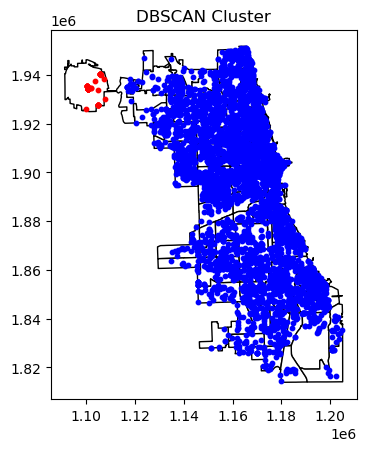

In [183]:
dbscan_model= DBSCAN(eps=7500, min_samples=2, metric='euclidean' ).fit(df_clus)   
plot(df_clus[:,1:3], dbscan_model.labels_, 'DBSCAN Cluster') 

because the clusterin is only 2 when we use this hyperparameter. Lets us play around with other combination of hyperparameter that have the next highest Silhouette Score

### 6.2 Hyperparameter: eps=4500, MinPts=2

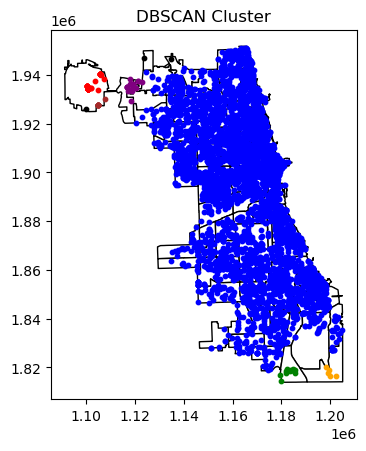

In [184]:
dbscan_model= DBSCAN(eps=4500, min_samples=2, metric='euclidean' ).fit(df_clus)   
plot(df_clus[:,1:3], dbscan_model.labels_, 'DBSCAN Cluster') 

### 6.2 Hyperparameter: eps=5000, MinPts=2

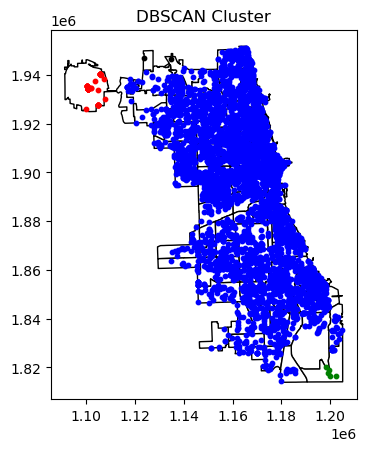

In [185]:
dbscan_model= DBSCAN(eps=5000, min_samples=2, metric='euclidean' ).fit(df_clus)   
plot(df_clus[:,1:3], dbscan_model.labels_, 'DBSCAN Cluster') 

## 7. Visualisation of ST-DBSCAN

### 7.1 Hyperparameter: eps=7500, MinPts=2

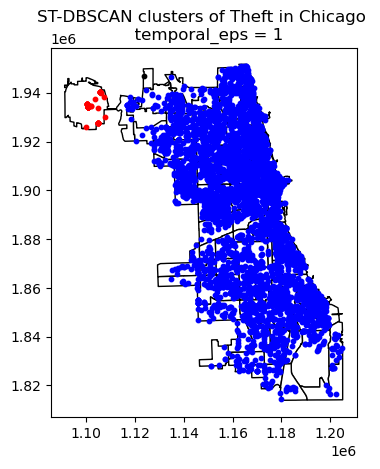

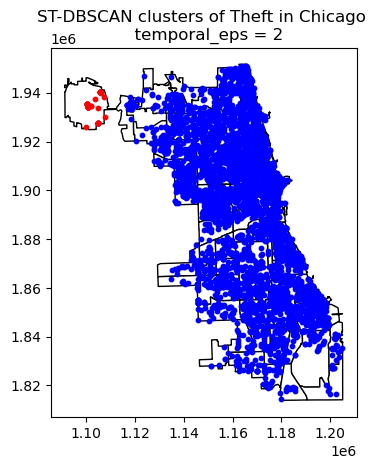

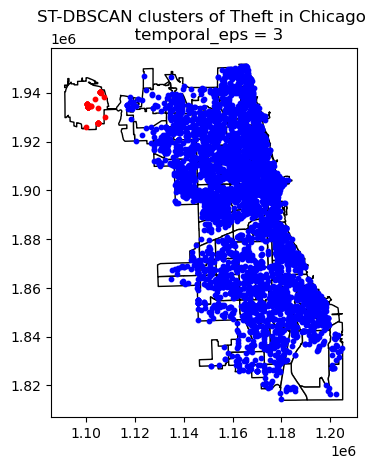

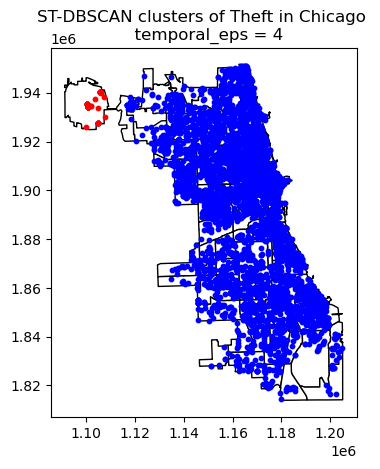

In [186]:
from st_dbscan import ST_DBSCAN

temporal_eps=[1,2,3,4]
#1:morning
#2:afternoon
#3:evening
#4:night
for st_eps2 in temporal_eps:
    st_dbscan = ST_DBSCAN(eps1 = 7500, eps2 = st_eps2, min_samples = 2) 
    st_dbscan.fit(df_clus) 
    plot(df_clus[:,1:3], st_dbscan.labels,'ST-DBSCAN clusters of Theft in Chicago \n'+'  temporal_eps = ' + str(st_eps2)) 

### 7.2 Hyperparameter: eps=4500, MinPts=2

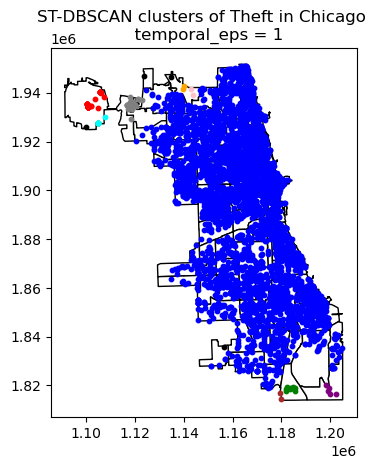

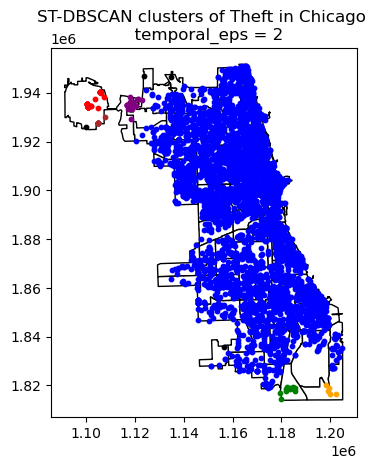

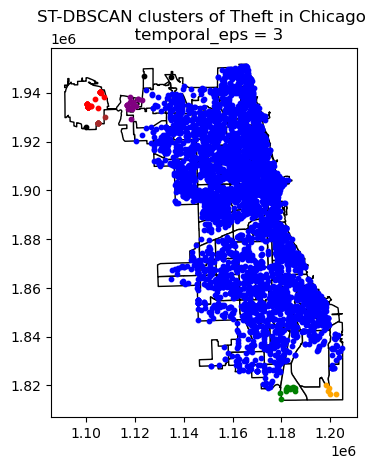

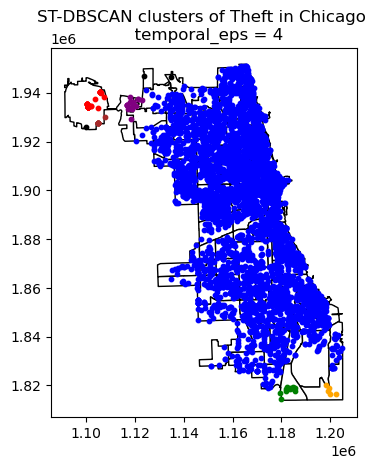

In [187]:
temporal_eps=[1,2,3,4]
#1:morning
#2:afternoon
#3:evening
#4:night
for st_eps2 in temporal_eps:
    st_dbscan = ST_DBSCAN(eps1 = 4500, eps2 = st_eps2, min_samples = 2) 
    st_dbscan.fit(df_clus) 
    plot(df_clus[:,1:3], st_dbscan.labels,'ST-DBSCAN clusters of Theft in Chicago \n'+'  temporal_eps = ' + str(st_eps2))

### 7.3 Hyperparameter: eps=5000, MinPts=2

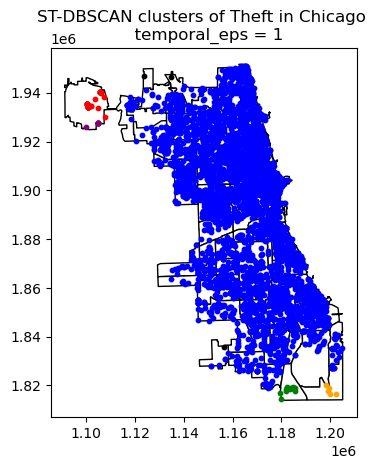

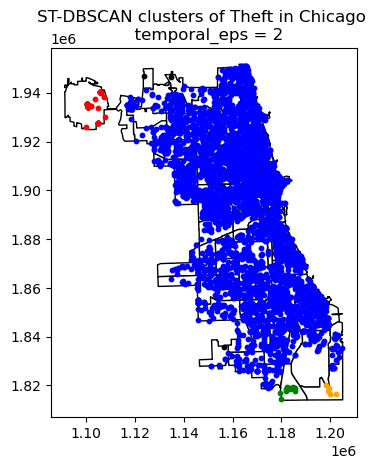

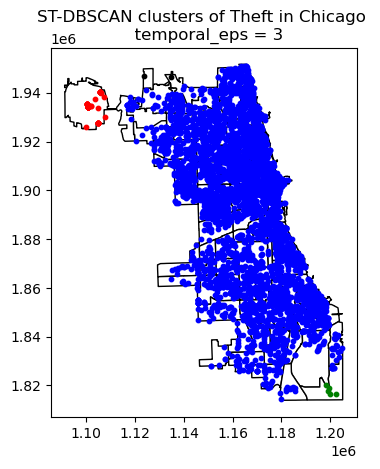

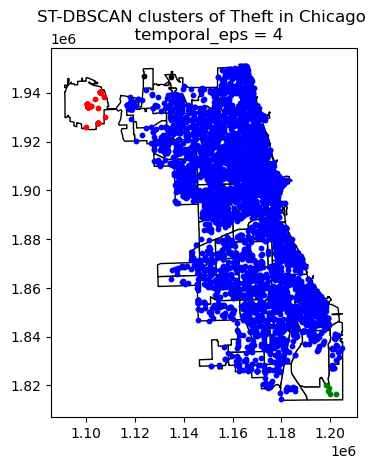

In [188]:
temporal_eps=[1,2,3,4]
#1:morning
#2:afternoon
#3:evening
#4:night
for st_eps2 in temporal_eps:
    st_dbscan = ST_DBSCAN(eps1 = 5000, eps2 = st_eps2, min_samples = 2) 
    st_dbscan.fit(df_clus) 
    plot(df_clus[:,1:3], st_dbscan.labels,'ST-DBSCAN clusters of Theft in Chicago \n'+'  temporal_eps = ' + str(st_eps2))